In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from itertools import product
from tqdm.notebook import tqdm

import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
from scipy.special import binom
from scipy.stats import uniform

from tick.base import TimeFunction

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson

In [2]:
mpl.rcParams["figure.figsize"] = (15,8)
plt.style.use("bmh")

In [3]:
def get_bin_counts(sample):
    bin_counts = pd.DataFrame(sample['bin_j'].value_counts()).sort_index()
    return bin_counts

## Continuous

We have an assumed nonhomogeneous Poisson Process with rate function as follows:

$ 
\lambda(t) = \alpha + \cos(\omega t)
$

For continuous time observations, log likelihood is of form:

$ 
l(\alpha, \omega; t_1, t_2, ..., t_n) = \sum_{i=1}^n \log(\alpha + \cos(\omega t_i)) - (\alpha T + \frac{1}{\omega} \sin(\omega T))
$

Jacobian is of form:

\begin{equation*}
    \begin{aligned}
        \frac{\partial l}{\partial \alpha} &= \sum_{i=1}^n \frac{1}{\lambda(t_i)} - T \\
        \frac{\partial l}{\partial \omega} &= - \sum_{i=1}^n \frac{t_i \sin(\omega t_i)}{\lambda(t_i)} - \frac{\omega T \cos(\omega T) - \sin(\omega T)}{\omega^2}.
    \end{aligned}
\end{equation*}

In [4]:
def lambda_t(t, omega):
    """
    Calculates lambda(t) = 1 + cos(omega * t) for all provided values of t.
    Returned array is of same dimension as provided t array, it is the intensity at each time point.
    """
    return 1 + np.cos(omega * t)

def T_integral(T, omega):
    return T + np.sin(omega * T)/omega


def log_likeli(timestamps, T, omega):
    """
    Evaluates log-likelihood for observed timestamps over period T.
    """
    return np.sum(
        np.log(lambda_t(timestamps, omega))
    ) - T_integral(T, omega)


def jacobian(timestamps, T, omega):
    lambda_t_inv = 1/lambda_t(timestamps, omega)
    
    jacobian = (
        - np.sum(
            timestamps * np.sin(omega * timestamps)
            * lambda_t_inv
        )
        - T * np.cos(omega * T) / omega
        + np.sin(omega * T) / omega**2
    )
    
    return jacobian


def hessian(timestamps, T, omega):
    lambda_t_squared_inv = 1/lambda_t(timestamps, omega) ** 2
        
    #d^2l/d(omega)^2
    hessian = -np.sum(
        timestamps**2 
        * (np.cos(omega*timestamps) + 1)
        * lambda_t_squared_inv
    ) + (1 / omega**3) * (
        (omega**2 * T**2 - 2) * np.sin(omega * T)
        + 2 * omega * T * np.cos(omega * T)
    )
    
    return hessian


def get_mle(timestamps, T, init_omega, bounds=None, constraints=None, method=None):
    mle = minimize(
        fun=lambda *omega: -log_likeli(timestamps, T, *omega), x0=init_omega, method=method,
#         jac=lambda omega: -jacobian(timestamps, T, omega),
#         hess=lambda omega: -hessian(timestamps, T, omega),
        constraints=constraints,
        bounds=bounds,
    )
    return mle

For binned-data with N $\Delta$-width bins (with associated counts $n_0, n_1, ..., n_{N-1}$), log-likelihood is of form:

$l(x_0, x_1, x_2; n_0, ..., n_{N-1}) = \sum_{k=0}^{N-1} n_k \Lambda(B_k) - \Lambda(T)$

where Bin k $B_k = [k\Delta, (k+1)\Delta), \quad \quad$ Mean measure $\Lambda(B_k) = a\Delta + \frac{\sin((k+1) \Delta \omega) - \sin(k \Delta \omega)}{\omega}$

In [364]:
def mean_measure(delta, k, omega):
    return (
        delta
        + (
            np.sin((k+1) * delta * omega)
            - np.sin(k*delta*omega)
        ) / omega
    )

def mean_measures(bin_counts, delta, omega):
    return np.array([mean_measure(delta, k, omega) for k in bin_counts.index])


def binned_log_likeli(bin_counts, T, delta, omega):
    measures = mean_measures(bin_counts, delta, omega)
    return np.sum(
        bin_counts['bin_j'] * np.log(measures)
    ) - T_integral(T, omega)
    
def binned_jacobian(bin_counts, T, delta, omega):
    measure_invs = 1 / mean_measures(bin_counts, delta, omega)
    
    jacobian = (
        delta
        * np.sum([
            (k + 1) * np.cos((k+1) * delta * omega)
            - k * np.cos(k * delta * omega)
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs) / omega 
        
        - np.sum([
            np.sin((k+1) * delta * omega)
            - np.sin(k * delta * omega)
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs) / omega**2
        
        - T * np.cos(omega * T) / omega
        + np.sin(omega * T) / omega**2
    )
    
    return jacobian


def binned_hessian(bin_counts, T, delta, omega):
    measure_invs = 1 / mean_measures(bin_counts, delta, omega)
    
    hessian = (
        delta ** 2 / omega * np.sum([
            k ** 2 * np.sin(k * delta * omega)
            - ((k + 1) ** 2) * np.sin((k + 1) * delta * omega)
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs)
        
        + (2 / omega ** 3) * np.sum([
            np.sin((k + 1) * delta * omega) - np.sin(k * delta * omega)
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs)
        
        - np.sum([
            (k + 1) * np.cos((k + 1) * delta * omega) - k * np.cos(k * delta * omega)
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs)
        
        - np.sum([
            ((delta / omega) * (
                (k + 1) * np.cos((k + 1) * delta * omega) - k * np.cos(k * delta * omega)
            )
            - (1 / omega ** 2) * (
                np.sin((k + 1) * delta * omega) - np.sin(k * delta * omega)
            )) ** 2
            for k in bin_counts.index
        ] * bin_counts['bin_j'] * measure_invs ** 2)
    ) + (1 / omega**3) * (
        (omega**2 * T**2 - 2) * np.sin(omega * T)
        + 2 * omega * T * np.cos(omega * T)
    )
    
    return hessian

def get_binned_mle(bin_counts, delta, T, init_omega, bounds=None, method=None):
    binned_mle = minimize(
        fun=lambda omega: -binned_log_likeli(bin_counts, T, delta, *omega), x0=init_omega, method=method,
#         jac=lambda omega: -binned_jacobian(bin_counts, T, delta, omega),
#         bounds=bounds
    )
    return binned_mle

In [528]:
def get_min_N(omega, T):
    req_delta = np.pi / (omega)
    
    N = int(np.ceil(T / req_delta))
    return N

In [529]:
omega = np.pi
delta = 4
T= 60
T / delta

15.0

𝜔_hat=3.126, binned_𝜔_hat=3.470
N 13 
delta 1.9230769230769231 
delta/omega 0.6121343965072898 
binned_omega_hat 4.093792297444143
True Value: 3.142, MLE: 3.127, Binned MLE: 4.094


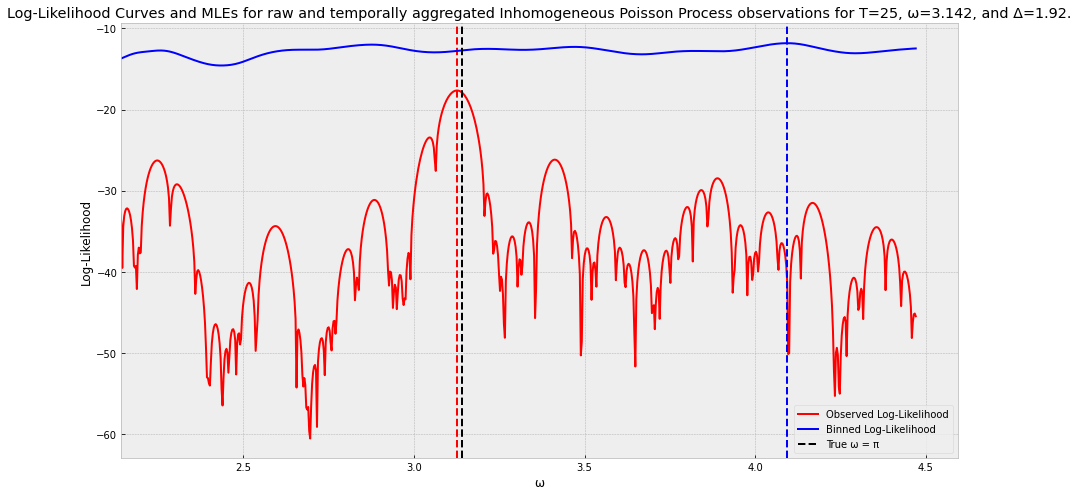

In [702]:
omega = np.pi
T = 25 # length of observations
N = 13
delta = T/N

t = np.linspace(0, T, num=max(T*10, 1000))
Y = lambda_t(t, omega)

tf = TimeFunction((t, Y))

# We define NHPP with the intensity function above
in_poi = SimuInhomogeneousPoisson([tf], end_time=T, verbose=False)
# We activate intensity tracking and launch simulation
in_poi.track_intensity(0.1)
in_poi.simulate()

# We plot the resulting inhomogeneous Poisson process with its
# intensity and its ticks over time


timestamps = in_poi.timestamps[0]
sample = pd.DataFrame(timestamps, columns=['t'])
sample['bin_j'] = sample['t'].apply(lambda x: int(np.floor((x/delta))))
bin_counts = get_bin_counts(sample)

# fig, (ax1, ax2) = plt.subplots(1, 2)
# plot_point_process(in_poi, ax=ax1)
# ax1.set_title('Plot of rate function with event timestamps')
# ax1.set_xlabel('t')
# ax1.set_ylabel('λ(t)')
# ax1.set_yticks((0, 1, 2))
# ax2.hist(timestamps, bins=N)
# ax2.set_title(f'Plot of temporally aggregated event counts with Δ={delta:.2f}')
# ax2.set_xlabel('t')
# ax2.set_ylabel('Bin Event Count')
# ax2.set_yticks((0, 1, 2, 3))
# ax2.set_xlim(0, T)
# plt.savefig("./thesis/nhpp_periodic_unid.pdf")

mle = get_mle(timestamps, T, init_omega=(omega,), bounds=[(0.1, None)])
binned_mle = get_binned_mle(bin_counts, delta, T, init_omega=(omega,), bounds=[(0.1, None)])

omega_hat, = mle.x
binned_omega_hat, = binned_mle.x
print(f"𝜔_hat={omega_hat:.3f}, binned_𝜔_hat={binned_omega_hat:.3f}")

omegas = np.linspace(0.5 * omega + 0.05, max(omega+1, binned_omega_hat+1), num=1000)
log_likelihoods = [log_likeli(timestamps, T, om) for om in omegas]
omega_hat = omegas[np.argmax(log_likelihoods)]
binned_log_likelihoods = [binned_log_likeli(bin_counts, T, delta, om) for om in omegas]
binned_omega_hat = omegas[np.argmax(binned_log_likelihoods)]
print("N", N, "\ndelta", delta, "\ndelta/omega", delta/omega, "\nbinned_omega_hat", binned_omega_hat)



plt.figure()
plt.plot(omegas, log_likelihoods, label='Observed Log-Likelihood', c='red')
plt.axvline(x=omega_hat, c='red', ls='--')
plt.plot(omegas, binned_log_likelihoods, label='Binned Log-Likelihood', c='blue')
plt.axvline(x=binned_omega_hat, c='blue', ls='--')
plt.axvline(x=omega, c='black', ls='--', label=f'True ω = π')
plt.legend()
plt.ylabel('Log-Likelihood')
plt.xlabel('ω')
plt.title(f'Log-Likelihood Curves and MLEs for raw and temporally aggregated Inhomogeneous Poisson Process observations for T={T}, ω={omega:.3f}, and Δ={delta:.2f}.')
plt.xlim(max(0, min(omega - 1, binned_omega_hat - 0.5)), max(omega+1, binned_omega_hat+0.5))
# plt.savefig("./thesis/nhpp_periodic_unid_log_likeli.pdf")
print(f"True Value: {omega:.3f}, MLE: {omega_hat:.3f}, Binned MLE: {binned_omega_hat:.3f}")

In [407]:
def simulate_and_estimate(omega, T, N, n_sims=1000):
    mles = []
    binned_mles = []
    hesses = []
    binned_hesses = []
    
    delta = T/N
    t = np.linspace(0, T, num=max(T*10, 1000))
    Y = lambda_t(t, omega)
    tf = TimeFunction((t, Y))
    for i in tqdm(range(n_sims)):
        in_poi = SimuInhomogeneousPoisson([tf], end_time=T, verbose=False)
        in_poi.track_intensity(0.1)
        in_poi.simulate()
        timestamps = in_poi.timestamps[0]
        sample = pd.DataFrame(timestamps, columns=['t'])
        sample['bin_j'] = sample['t'].apply(lambda x: int(np.floor((x/delta))))
        bin_counts = get_bin_counts(sample)
        
        mle = get_mle(timestamps, T, init_omega=(omega,), bounds=[(0.1, None)])
        binned_mle = get_binned_mle(bin_counts, delta, T, init_omega=(omega,), bounds=[(0.1, None)])
        omega_hat, = mle.x
        binned_omega_hat, = binned_mle.x
        omegas = np.linspace(0.5 * omega + 0.05, max(omega+1, binned_omega_hat+1), num=1000)
        log_likelihoods = [log_likeli(timestamps, T, om) for om in omegas]
        omega_hat = omegas[np.argmax(log_likelihoods)]
        binned_log_likelihoods = [binned_log_likeli(bin_counts, T, delta, om) for om in omegas]
        binned_omega_hat = omegas[np.argmax(binned_log_likelihoods)]
        
        mles.append(omega_hat)
        binned_mles.append(binned_omega_hat)
        
        hess = hessian(timestamps, T, omega_hat)
        binned_hess = binned_hessian(bin_counts, T, delta, binned_omega_hat)
        
        hesses.append(hess)
        binned_hesses.append(binned_hess)
    mles = pd.DataFrame(mles)
    binned_mles = pd.DataFrame(binned_mles)
    mle_errors = omega - mles
    binned_mle_errors = omega - binned_mles
    
    hesses = pd.DataFrame(hesses)
    binned_hesses = pd.DataFrame(binned_hesses)
    
    return mles, binned_mles, mle_errors, binned_mle_errors, hesses, binned_hesses

# Slightly above Threshold

In [687]:
omega = np.pi
T = 25 # length of observations
N = get_min_N(omega, T) + 1 # number of bins
delta = T/N
print(N, delta)
print(delta / omega)

26 0.9615384615384616
0.3060671982536449


In [663]:
print(N)
mles, binned_mles, mle_errors, binned_mle_errors, hesses, binned_hesses = simulate_and_estimate(omega, T, N)

In [664]:
print(mle_errors.mean()[0])
print(binned_mle_errors.mean()[0])
print(mle_errors.std()[0])
print(binned_mle_errors.std()[0])

0.008269746004692248
0.05529736129917252
0.15475652026581985
0.42620392626871334


In [731]:
binned_hesses.mean()

0   -1635.286075
dtype: float64

In [665]:
print(binned_mle_errors.std()[0] / mle_errors.std()[0])

2.7540288805708335


In [727]:
1 - binned_hesses.mean() / good_hesses.mean()

0    0.6295
dtype: float64

In [728]:
1 - good_binned_hesses.mean() / good_hesses.mean()

0    0.253965
dtype: float64

In [729]:
1 - bad_binned_hesses.mean() / bad_hesses.mean()

0    0.847198
dtype: float64

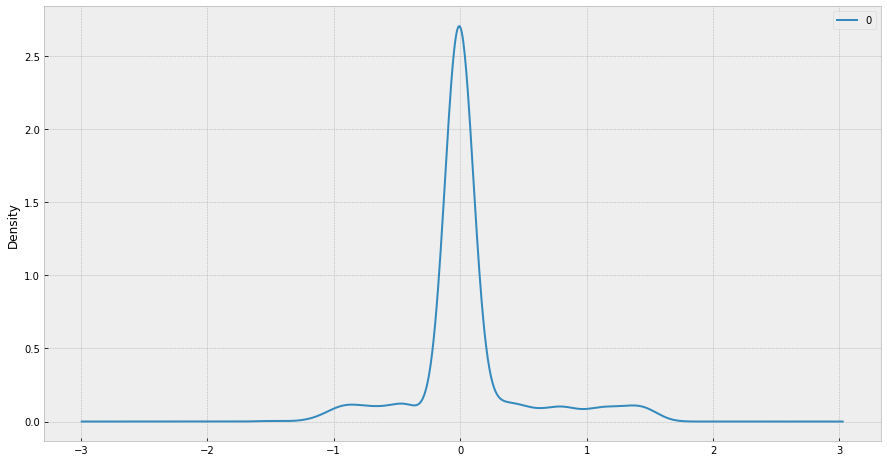

In [668]:
binned_mle_errors.plot.kde()

# Worse than threshold

In [690]:
omega = np.pi
T = 25 # length of observations
N = int(get_min_N(omega, T) / 2) + 1 # number of bins
delta = T/N
print(N, delta)
print(delta / omega)

13 1.9230769230769231
0.6121343965072898


In [691]:
print(N)
bad_mles, bad_binned_mles, bad_mle_errors, bad_binned_mle_errors, bad_hesses, bad_binned_hesses = simulate_and_estimate(omega, T, N)

13


In [692]:
print(bad_mle_errors.mean()[0])
print(bad_binned_mle_errors.mean()[0])
print(bad_mle_errors.std()[0])
print(bad_binned_mle_errors.std()[0])

-0.014903857003126708
0.5076449118712946
0.2775802326674535
0.8560326360722539


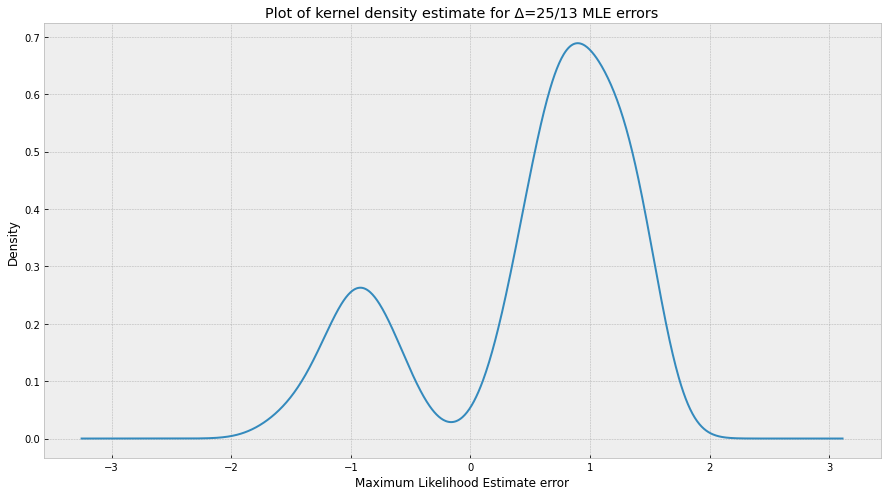

In [723]:
bad_binned_mle_errors[0].plot.kde()
plt.title("Plot of kernel density estimate for Δ=25/13 MLE errors")
plt.xlabel("Maximum Likelihood Estimate error")
plt.savefig("./thesis/overaggregated_error_kde.pdf")

In [713]:
hesses.mean()

0   -4347.716254
dtype: float64

In [703]:
bad_binned_hesses.mean()

0   -681.789516
dtype: float64

# Much better than threshold

In [683]:
omega = np.pi
T = 25 # length of observations
N = int(2 * get_min_N(omega, T)) # number of bins
delta = T/N
print(N, delta)
print(delta / omega)

50 0.5
0.15915494309189535


In [684]:
print(N)
good_mles, good_binned_mles, good_mle_errors, good_binned_mle_errors, good_hesses, good_binned_hesses = simulate_and_estimate(omega, T, N)

In [685]:
print(good_mle_errors.mean()[0])
print(good_binned_mle_errors.mean()[0])
print(good_mle_errors.std()[0])
print(good_binned_mle_errors.std()[0])

0.0010421602669091166
0.015906802464952453
0.11481395849179213
0.2780580495153665


In [715]:
good_hesses.mean()

0   -4413.726502
dtype: float64

In [716]:
good_binned_hesses.mean()

0   -3292.793342
dtype: float64

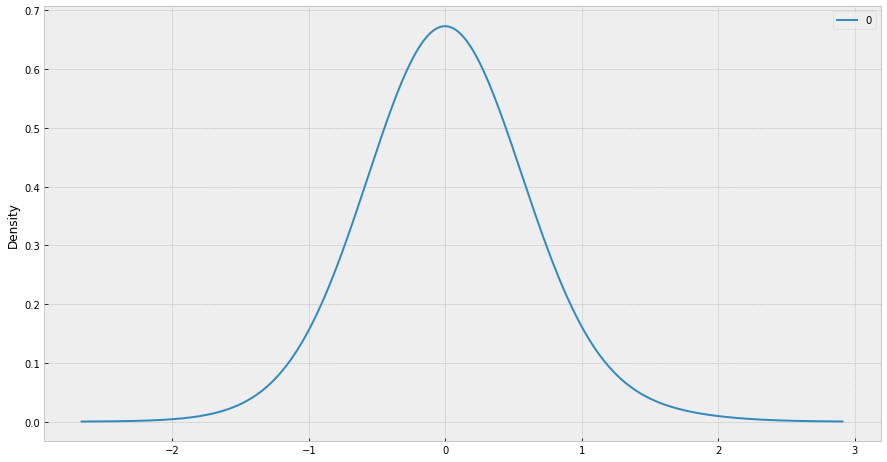

In [689]:
good_binned_mle_errors.plot.kde(2)
# plt.xlim(-0.05, 0.05)